# Content: Explorative analysis of the evidence_log
0. Initialisation
1. Examination of raw evidence log
* Analysis: How often does a user read the same article?
* Conclusion: reduced evidence log to only contain one read per article per user
2. Analyse number of articles read per person
3. Analyse which articles are read


# 0. Initialisation

In [2]:
import logging
import os
import sys
import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt


sys.path.insert(0, os.getcwd())
from recommender_engine.data_layer.db_connect import return_evidence_log

## Create products bought together
## https://towardsdatascience.com/apriori-association-rule-mining-explanation-and-python-implementation-290b42afdfc6

In [3]:
# functions for calculating quantiels and others relevant statistics
def q25(x):
    return x.quantile(0.25)

def q50(x):
    return x.quantile(0.5)

def q75(x):
    return x.quantile(0.75)

def lower_fence(x):
    Q1 = q25(x)
    Q3 = q75(x)
    IQR = Q3 - Q1
    return Q1 - (1.5 * IQR)

def upper_fence(x):
    Q1 = q25(x)
    Q3 = q75(x)
    IQR = Q3 - Q1
    return Q3 + (1.5 * IQR)

In [4]:
# Get evidence log from bigquery
evidence_log_df = return_evidence_log()
evidence_log_df.head()


/Users/regitzesdun/Repos_wawa/wawa-recommender-engine/venv/lib/python3.9/site-packages/pandas/io/sql.py:1405: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  return self.connectable.execution_options().execute(*args, **kwargs)


,slug,original_timestamp,category,user_id,referrer,article_id,base_article_id
0,ved-du-hvad-aeglosningsfasen-indeholder-iui,2022-08-29 11:52:05+00:00,Fertilitetsbehandling,54901615-67C9-42FD-BF7C-BF0F0D48E4F7,home,i18n.001db2b8-07ed-4811-a72e-3e992cada878.da-DK,001db2b8-07ed-4811-a72e-3e992cada878
1,ved-du-hvad-aeglosningsfasen-indeholder-iui,2022-09-07 17:55:15+00:00,Fertilitetsbehandling,DFBEB77D-9ECF-401F-9324-FCFE79C57C1A,home,i18n.001db2b8-07ed-4811-a72e-3e992cada878.da-DK,001db2b8-07ed-4811-a72e-3e992cada878
2,ved-du-hvad-aeglosningsfasen-indeholder-iui,2022-01-20 11:04:33+00:00,None,5F7D084F-C63A-4F60-9758-0A5D7D76CDDF,home,i18n.001db2b8-07ed-4811-a72e-3e992cada878.da-DK,001db2b8-07ed-4811-a72e-3e992cada878
3,ved-du-hvad-aeglosningsfasen-indeholder-iui,2022-09-03 23:40:42+00:00,Fertilitetsbehandling,5BA42372-5D0F-414D-9156-D21874E3E25C,home,i18n.001db2b8-07ed-4811-a72e-3e992cada878.da-DK,001db2b8-07ed-4811-a72e-3e992cada878
4,ved-du-hvad-aeglosningsfasen-indeholder-iui,2022-06-25 08:16:19+00:00,Fertilitetsbehandling,B1C876F2-FAE8-4839-89DF-38231CE4C284,home,i18n.001db2b8-07ed-4811-a72e-3e992cada878.da-DK,001db2b8-07ed-4811-a72e-3e992cada878


# 1. Examination of raw evidence log

In [5]:
## KEY NUMBERS
print(f"There are no duplicates in the raw evidence log: {evidence_log_df[evidence_log_df.duplicated()].empty}")
print(f"Total number of articles read {len(evidence_log_df)}")
print(f"Number of unique users having read an article: {evidence_log_df.user_id.nunique()}")
print(f"Number of unique articles having been read: {evidence_log_df.article_id.nunique()}")
print(f"Number of unique base articles having been read: {evidence_log_df.base_article_id.nunique()}")

There are no duplicates in the raw evidence log: True
Total number of articles read 19385
Number of unique users having read an article: 1599
Number of unique articles having been read: 823
Number of unique base articles having been read: 642


In [6]:
## CREATE A PROXY FOR THE BASE_ARTICLE_SLUG AND ADDING IT TO THE EVIDENCE LOG
# Taking the first slug available
article_titles_df = evidence_log_df[['base_article_id','slug']].drop_duplicates().groupby('base_article_id').slug.first().reset_index()
article_titles_df = article_titles_df.rename(columns={'slug':'base_article_slug'})
# article_titles_df.head()

evidence_log_df = pd.merge(evidence_log_df, article_titles_df, on='base_article_id')
evidence_log_df.head()

,slug,original_timestamp,category,user_id,referrer,article_id,base_article_id,base_article_slug
0,ved-du-hvad-aeglosningsfasen-indeholder-iui,2022-08-29 11:52:05+00:00,Fertilitetsbehandling,54901615-67C9-42FD-BF7C-BF0F0D48E4F7,home,i18n.001db2b8-07ed-4811-a72e-3e992cada878.da-DK,001db2b8-07ed-4811-a72e-3e992cada878,ved-du-hvad-aeglosningsfasen-indeholder-iui
1,ved-du-hvad-aeglosningsfasen-indeholder-iui,2022-09-07 17:55:15+00:00,Fertilitetsbehandling,DFBEB77D-9ECF-401F-9324-FCFE79C57C1A,home,i18n.001db2b8-07ed-4811-a72e-3e992cada878.da-DK,001db2b8-07ed-4811-a72e-3e992cada878,ved-du-hvad-aeglosningsfasen-indeholder-iui
2,ved-du-hvad-aeglosningsfasen-indeholder-iui,2022-01-20 11:04:33+00:00,None,5F7D084F-C63A-4F60-9758-0A5D7D76CDDF,home,i18n.001db2b8-07ed-4811-a72e-3e992cada878.da-DK,001db2b8-07ed-4811-a72e-3e992cada878,ved-du-hvad-aeglosningsfasen-indeholder-iui
3,ved-du-hvad-aeglosningsfasen-indeholder-iui,2022-09-03 23:40:42+00:00,Fertilitetsbehandling,5BA42372-5D0F-414D-9156-D21874E3E25C,home,i18n.001db2b8-07ed-4811-a72e-3e992cada878.da-DK,001db2b8-07ed-4811-a72e-3e992cada878,ved-du-hvad-aeglosningsfasen-indeholder-iui
4,ved-du-hvad-aeglosningsfasen-indeholder-iui,2022-06-25 08:16:19+00:00,Fertilitetsbehandling,B1C876F2-FAE8-4839-89DF-38231CE4C284,home,i18n.001db2b8-07ed-4811-a72e-3e992cada878.da-DK,001db2b8-07ed-4811-a72e-3e992cada878,ved-du-hvad-aeglosningsfasen-indeholder-iui


### Analysis: How often does a user read the same article?

In [7]:
num_times_read_per_user_df = evidence_log_df \
    .groupby(['user_id','base_article_id','base_article_slug']) \
        .original_timestamp.count() \
            .reset_index() \
                .rename(columns={'original_timestamp':'num_times_read_per_user'}) \
                    .sort_values(by='num_times_read_per_user')

bins = [0,1,2,3,4,5,10,20,30,40,50,max(num_times_read_per_user_df['num_times_read_per_user'])]
num_times_read_per_user_df = num_times_read_per_user_df \
    .groupby(pd.cut(num_times_read_per_user_df['num_times_read_per_user'],bins).rename('bins'))\
        .agg({'num_times_read_per_user':['count','sum']})\
            .reset_index() 

num_times_read_per_user_df.columns = num_times_read_per_user_df.columns.to_flat_index()
num_times_read_per_user_df = num_times_read_per_user_df.rename(columns={('num_times_read_per_user', 'sum'):'total_reads',('num_times_read_per_user', 'count'):'total_occurences'})

num_times_read_per_user_df['percentage_of_total_reads'] = round(num_times_read_per_user_df['total_reads']/num_times_read_per_user_df['total_reads'].sum()*100,2)
num_times_read_per_user_df['percentage_of_occurences'] = round(num_times_read_per_user_df['total_occurences']/num_times_read_per_user_df['total_occurences'].sum()*100,2)

num_times_read_per_user_df

,"(bins, )",total_occurences,total_reads,percentage_of_total_reads,percentage_of_occurences
0,"(0, 1]",10194,10194,52.59,77.92
1,"(1, 2]",1519,3038,15.67,11.61
2,"(2, 3]",667,2001,10.32,5.10
3,"(3, 4]",262,1048,5.41,2.00
4,"(4, 5]",171,855,4.41,1.31
5,"(5, 10]",226,1630,8.41,1.73
6,"(10, 20]",41,516,2.66,0.31
7,"(20, 30]",2,50,0.26,0.02
8,"(30, 40]",0,0,0.00,0.00
9,"(40, 50]",0,0,0.00,0.00


### Conclusion

In [8]:
print(f"Articles being read once account for {num_times_read_per_user_df.loc[0,'percentage_of_occurences']} % of the occurences of articles being read, but only accounts for {num_times_read_per_user_df.loc[0,'percentage_of_total_reads']} % of total articles read.")

print(f"Whereas articles being read more than twice account of {num_times_read_per_user_df.loc[2:,'percentage_of_occurences'].sum()} % of the occurences, but {num_times_read_per_user_df.loc[2:,'percentage_of_total_reads'].sum()} % of the total articles read.")

print("We attribute this to an error in the tracking data, as it seems unlikely that that many will be reading the same article again and again, and for this analysis we are not interested in the duplicates. So we remove any read of article that is more than one.")


Articles being read once account for 77.92 % of the occurences of articles being read, but only accounts for 52.59 % of total articles read.
Whereas articles being read more than twice account of 10.48 % of the occurences, but 31.74 % of the total articles read.
We attribute this to an error in the tracking data, as it seems unlikely that that many will be reading the same article again and again, and for this analysis we are not interested in the duplicates. So we remove any read of article that is more than one.


We want to have a dataframe some consists 

* base_article_slug
* base_article_id
* user_id
* latest_timestamp_of_article_read

In [9]:
reduced_evidence_log_df = evidence_log_df.groupby(['base_article_id','base_article_slug','user_id']).original_timestamp.last().reset_index()
reduced_evidence_log_df['month_year']=reduced_evidence_log_df['original_timestamp'].dt.to_period('M')

reduced_evidence_log_df

/var/folders/ng/4r8hsmqn2gj0jqj40cy4q5880000gn/T/ipykernel_6617/3910806953.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  reduced_evidence_log_df['month_year']=reduced_evidence_log_df['original_timestamp'].dt.to_period('M')


,base_article_id,base_article_slug,user_id,original_timestamp,month_year
0,001db2b8-07ed-4811-a72e-3e992cada878,ved-du-hvad-aeglosningsfasen-indeholder-iui,00CE41ED-45EA-4C34-9148-F9B7027F71F0,2022-02-23 12:19:27+00:00,2022-02
1,001db2b8-07ed-4811-a72e-3e992cada878,ved-du-hvad-aeglosningsfasen-indeholder-iui,05D19244-6CF2-4970-AC92-30FD92756668,2021-12-31 21:52:43+00:00,2021-12
2,001db2b8-07ed-4811-a72e-3e992cada878,ved-du-hvad-aeglosningsfasen-indeholder-iui,0899017E-BDCE-4A39-BF61-469117EF24E7,2022-06-27 09:47:39+00:00,2022-06
3,001db2b8-07ed-4811-a72e-3e992cada878,ved-du-hvad-aeglosningsfasen-indeholder-iui,0A0FA8AF-F49A-4880-B58B-188F2C565CB2,2022-04-08 22:25:20+00:00,2022-04
4,001db2b8-07ed-4811-a72e-3e992cada878,ved-du-hvad-aeglosningsfasen-indeholder-iui,0B8F8784-5D18-4CF9-A32D-2C2CB5CFD397,2022-03-01 14:31:33+00:00,2022-03
...,...,...,...,...,...
13078,ffb0976d-ac49-41cd-9a41-c28c3cbc31a5,"donorbarn-eva:-""vi-har-alle-brug-for-at-kende-...",A09108BC-8C3F-4A83-ACAA-0FCAE3EA257E,2022-02-22 23:42:48+00:00,2022-02
13079,ffb0976d-ac49-41cd-9a41-c28c3cbc31a5,"donorbarn-eva:-""vi-har-alle-brug-for-at-kende-...",C5414A5E-1F02-49D5-A102-2136FF502419,2022-02-03 19:01:17+00:00,2022-02
13080,ffb0976d-ac49-41cd-9a41-c28c3cbc31a5,"donorbarn-eva:-""vi-har-alle-brug-for-at-kende-...",C9F34773-59C7-43F0-9E5F-0032FE7EFD64,2022-05-28 11:58:14+00:00,2022-05
13081,ffb0976d-ac49-41cd-9a41-c28c3cbc31a5,"donorbarn-eva:-""vi-har-alle-brug-for-at-kende-...",c8c3ef35-3a21-4e61-ba8d-eeab3fade920,2022-12-27 23:13:48.452000+00:00,2022-12


In [11]:
## KEY NUMBERS FOR REDUCED EVIDENCE LOG
print(f"Total number of articles read: {len(reduced_evidence_log_df)}")
print(f"Number of unique users having read an article: {reduced_evidence_log_df.user_id.nunique()}")
print(f"Number of unique base articles having been read: {reduced_evidence_log_df.base_article_id.nunique()}")
reduced_evidence_log_df.to_csv('reduced_evidence_log.csv',index=0)

Total number of articles read: 13083
Number of unique users having read an article: 1599
Number of unique base articles having been read: 642


## 2. Analyse number of articles read per person

In [53]:
articles_read_by_user_df = reduced_evidence_log_df \
    .groupby('user_id') \
        .base_article_id.count() \
            .reset_index() \
                .rename(columns={'base_article_id':'number_of_articles_read_per_user'}) \
                    .sort_values(by='number_of_articles_read_per_user',ascending=False)

articles_read_by_user_df.describe()

,number_of_articles_read_per_user
count,1599.000000
mean,8.181989
std,10.912843
min,1.000000
25%,2.000000
50%,4.000000
75%,10.000000
max,149.000000


25% of all users read less than or equal to 2.0
50% of all users read less than or equal to 4.0
75% of all users read less than or equal to 10.0
Having read more than 22.0 articles is categorised as outliers which can also be seen in the plot below:


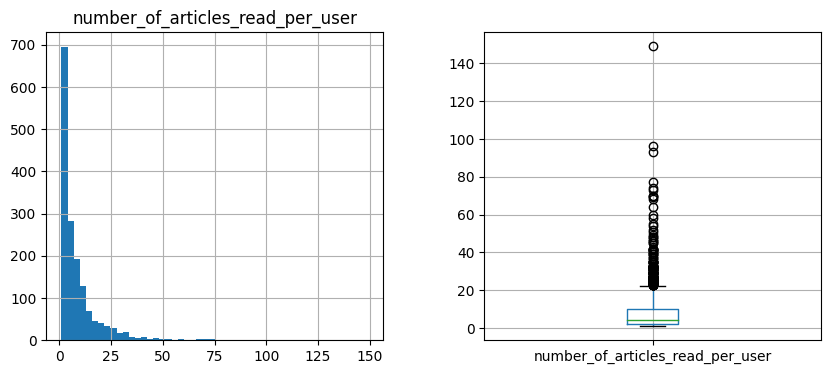

In [54]:
Q1 = q25(articles_read_by_user_df['number_of_articles_read_per_user'])
Q2 = q50(articles_read_by_user_df['number_of_articles_read_per_user'])
Q3 = q75(articles_read_by_user_df['number_of_articles_read_per_user'])
Upper_Fence = upper_fence(articles_read_by_user_df['number_of_articles_read_per_user'])

print(f"25% of all users read less than or equal to {Q1}")
print(f"50% of all users read less than or equal to {Q2}")
print(f"75% of all users read less than or equal to {Q3}")
print(f"Having read more than {Upper_Fence} articles is categorised as outliers which can also be seen in the plot below:")

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
articles_read_by_user_df.hist('number_of_articles_read_per_user', bins=50,ax=ax1)
articles_read_by_user_df.boxplot(column='number_of_articles_read_per_user',ax=ax2)
plt.show()


### monthly

In [55]:
monthly_articles_read_by_user_df = reduced_evidence_log_df.groupby(['month_year','user_id']).base_article_id.count().reset_index().rename(columns={'base_article_id':'number_of_articles_read'})
monthly_articles_read_by_user_df = monthly_articles_read_by_user_df.groupby(['month_year']).agg({'number_of_articles_read':[q25,q50,q75,'mean']}).reset_index()
monthly_articles_read_by_user_df.columns = monthly_articles_read_by_user_df.columns.to_flat_index()

monthly_articles_read_by_user_df = monthly_articles_read_by_user_df.rename( \
        columns={('month_year', ''):'month_year', \
                ('number_of_articles_read', 'q25'):'q25', \
                ('number_of_articles_read', 'q50'):'q50', \
                ('number_of_articles_read', 'q75'):'q75', \
                ('number_of_articles_read', 'mean'):'mean'})
                
monthly_articles_read_by_user_df

,month_year,q25,q50,q75,mean
0,2021-12,1.0,2.0,5.00,3.792308
1,2022-01,1.0,3.0,5.00,4.489583
2,2022-02,1.0,2.0,5.00,4.014870
3,2022-03,1.0,3.0,7.00,4.990610
4,2022-04,1.0,3.0,6.00,5.178378
5,2022-05,2.0,4.0,7.00,5.270833
6,2022-06,2.0,4.0,8.00,5.972376
7,2022-07,1.0,3.0,6.75,5.139344
8,2022-08,1.0,3.0,7.00,5.472727
9,2022-09,1.0,3.0,6.00,5.495495


<AxesSubplot: title={'center': 'Development in key metrics for number of articles read per user'}, xlabel='month_year'>

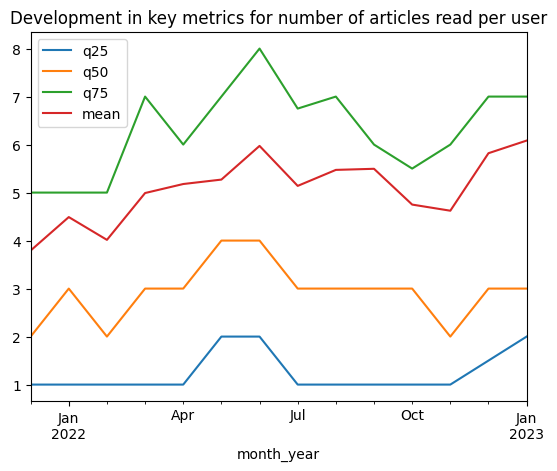

In [56]:
ax = plt.gca()

monthly_articles_read_by_user_df.plot(x='month_year',y='q25',ax=ax, title='Development in key metrics for number of articles read per user')
monthly_articles_read_by_user_df.plot(x='month_year',y='q50',ax=ax)
monthly_articles_read_by_user_df.plot(x='month_year',y='q75',ax=ax)
monthly_articles_read_by_user_df.plot(x='month_year',y='mean',ax=ax)

## 3. Analyse which articles are read

In [57]:
articles_read_df = reduced_evidence_log_df.groupby(['base_article_id','base_article_slug']).original_timestamp.count().reset_index().rename(columns={'original_timestamp':'occurences'})
articles_read_df.sort_values(by='occurences',ascending=False)

,base_article_id,base_article_slug,occurences
221,4c36389a-ede4-4da2-a5c8-661c2fb6b977,overblik-over-medicinkategorier-og-hvad-de-gor...,298
584,e6e6b791-e051-44a6-a8b3-2a289a0953d5,rad-til-parforhold-i-fertilitetsbehandling,203
349,833d240c-73fc-4b4f-a814-ef9bb96e9d2f,disse-begivenheder-skal-du-igennem-i-fertilite...,196
114,28a5d387-5f30-42a4-8959-8a24df37ba15,lutealfasen-kan-foles-lang-fordi-du-haber-pa-e...,195
284,66ce674e-25e7-444d-943d-f357a4b376ab,statistik-hvad-er-sandsynligheden-for-graviditet,170
...,...,...,...
93,22996270-38b1-4124-a101-e545e68e8f76,jordemoderen-udredning-og-fertilitetsbehandlin...,1
385,906b96b5-74d8-4e58-acbf-98ce97755e7a,svar-fra-sexologen-sporgsmal-om-sex-og-dating-...,1
328,7a2bf761-f7df-4d12-8951-6aeb3780c74f,om-spermiedonation-insemination-och-ivf,1
332,7d57de47-2df0-4e2d-b40d-3be86fd463b3,familieeksperten-graviditet-og-fertilitetsbeha...,1


<AxesSubplot: >

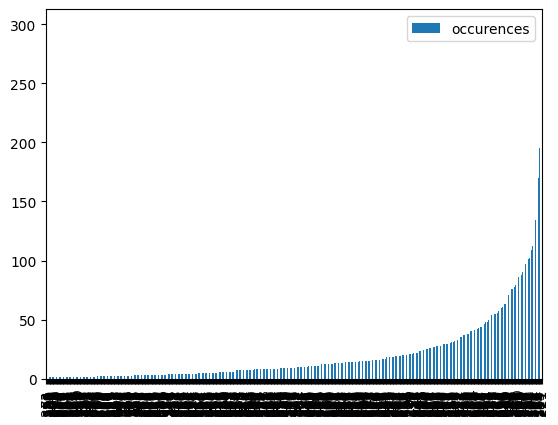

In [58]:
articles_read_df.sort_values(by='occurences').plot.bar(y='occurences')

array([[<AxesSubplot: title={'center': 'occurences'}>]], dtype=object)

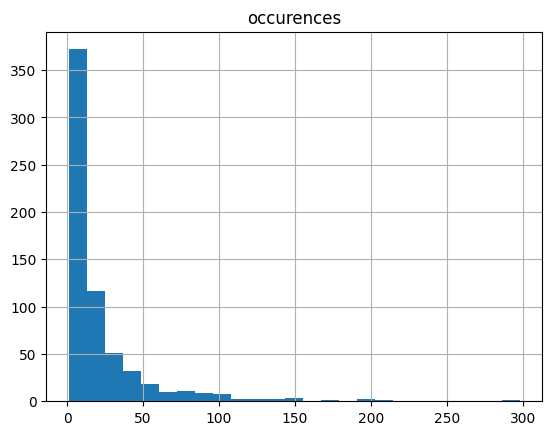

In [59]:
articles_read_df.hist(column='occurences', bins=25)
# The majority of articles are only being read a few times

In [60]:
bins = [0,10,20,30,40,50,60,70,80,90,100,200,max(articles_read_df['occurences'])]
articles_read_df.groupby(pd.cut(articles_read_df['occurences'],bins)).count()

,base_article_id,base_article_slug,occurences
occurences,,,
"(0, 10]",339,339,339
"(10, 20]",129,129,129
"(20, 30]",56,56,56
"(30, 40]",30,30,30
"(40, 50]",19,19,19
"(50, 60]",17,17,17
"(60, 70]",7,7,7
"(70, 80]",13,13,13
"(80, 90]",7,7,7


In [61]:
## Top 20 most read articles
articles_read_df.sort_values(by='occurences',ascending=False)[0:20]

,base_article_id,base_article_slug,occurences
221,4c36389a-ede4-4da2-a5c8-661c2fb6b977,overblik-over-medicinkategorier-og-hvad-de-gor...,298
584,e6e6b791-e051-44a6-a8b3-2a289a0953d5,rad-til-parforhold-i-fertilitetsbehandling,203
349,833d240c-73fc-4b4f-a814-ef9bb96e9d2f,disse-begivenheder-skal-du-igennem-i-fertilite...,196
114,28a5d387-5f30-42a4-8959-8a24df37ba15,lutealfasen-kan-foles-lang-fordi-du-haber-pa-e...,195
284,66ce674e-25e7-444d-943d-f357a4b376ab,statistik-hvad-er-sandsynligheden-for-graviditet,170
59,14ffeea2-82cf-4d46-b55e-76808bdb474e,de-fem-ting-kvinder-ofte-sporger-fertilitetsla...,154
100,252daca6-049e-449d-8593-e8f9cb7bc837,hvad-sker-der-i-stimulationsfasen-lang-kort,151
173,3bf6aab2-5d0e-429e-b419-e9aa87643f29,hvordan-kan-du-forberede-dig-pa-at-starte-i-fe...,149
24,08566c97-9877-46df-8b5b-e744e9dd7fcb,mentor:-hvordan-pavirker-stress-min-fertilitet,134
301,6e8c5d0d-18ab-4d27-9392-e7d3cb796a0e,terapeut:-sadan-handterer-du-nogle-af-de-svaer...,132


### monthly

In [62]:
reduced_evidence_log_df.groupby(['month_year','base_article_id']).original_timestamp.count().reset_index()

,month_year,base_article_id,original_timestamp
0,2021-12,001db2b8-07ed-4811-a72e-3e992cada878,3
1,2021-12,042818c1-47bf-4e0f-8543-807266fc86ed,1
2,2021-12,06022869-b200-4f5d-9ed1-d675b39ca0b4,1
3,2021-12,06e18a56-b420-437a-ba5d-13d0285d4627,8
4,2021-12,07cd21af-f03d-4766-80b2-2de03bd4ec13,1
...,...,...,...
3270,2023-01,fd575f5a-9a92-4405-b383-b11dbe0f78b9,3
3271,2023-01,fd668c9a-b87b-49c9-9d72-11a0677e17d8,4
3272,2023-01,fe0a74b9-7280-424b-879d-85e7c6b517fd,1
3273,2023-01,fe7750ce-c8b7-4166-a2d7-43312105a39b,1


In [63]:
monthly_articles_read_df = reduced_evidence_log_df.groupby(['month_year','base_article_id']).original_timestamp.count().reset_index().rename(columns={'original_timestamp':'number_of_times_read'})
monthly_articles_read_stats_df = monthly_articles_read_df.groupby(['month_year']).agg({'number_of_times_read':[q25,q50,q75,'mean']}).reset_index()
monthly_articles_read_stats_df.columns = monthly_articles_read_stats_df.columns.to_flat_index()

monthly_articles_read_stats_df = monthly_articles_read_stats_df.rename( \
        columns={('month_year', ''):'month_year', \
                ('number_of_times_read', 'q25'):'q25', \
                ('number_of_times_read', 'q50'):'q50', \
                ('number_of_times_read', 'q75'):'q75', \
                ('number_of_times_read', 'mean'):'mean'})

monthly_articles_read_stats_df

,month_year,q25,q50,q75,mean
0,2021-12,1.0,3.0,5.0,4.108333
1,2022-01,2.0,4.0,9.0,7.143646
2,2022-02,2.0,3.0,6.0,5.427136
3,2022-03,2.0,4.0,8.0,5.808743
4,2022-04,1.0,3.0,6.0,4.497653
5,2022-05,1.0,2.0,5.0,4.181818
6,2022-06,1.0,2.0,5.0,3.945255
7,2022-07,1.0,2.0,4.0,2.668085
8,2022-08,1.0,2.0,3.0,2.687500
9,2022-09,1.0,2.0,3.0,2.584746


<AxesSubplot: title={'center': 'Development in key metrics for number of times each article is read'}, xlabel='month_year'>

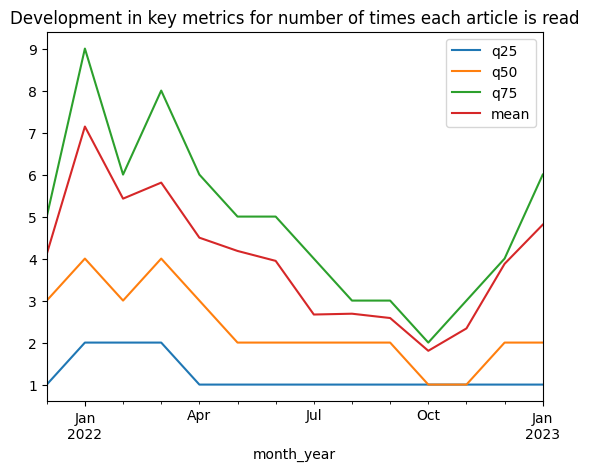

In [64]:
ax = plt.gca()

monthly_articles_read_stats_df.plot(x='month_year',y='q25',ax=ax, title='Development in key metrics for number of times each article is read')
monthly_articles_read_stats_df.plot(x='month_year',y='q50',ax=ax)
monthly_articles_read_stats_df.plot(x='month_year',y='q75',ax=ax)
monthly_articles_read_stats_df.plot(x='month_year',y='mean',ax=ax)

In [65]:
leading_month_for_analysis = '2022-12'
monthly_pivot_df = monthly_articles_read_df.pivot_table(columns='month_year',index=['base_article_id','base_article_slug'],values='number_of_times_read',aggfunc='sum').reset_index()
monthly_pivot_df.columns = [str(i) for i in monthly_pivot_df.columns]
monthly_pivot_df = monthly_pivot_df.sort_values(by=leading_month_for_analysis,ascending=False)
monthly_pivot_df = monthly_pivot_df.fillna(0).reset_index(drop=True)
monthly_pivot_df = monthly_pivot_df.set_index('base_article_slug').drop(columns=['base_article_id'])

ax = monthly_pivot_df[0:10].T.plot(figsize=(18, 10))
ax.set_ylabel('Absolute Power (log)', fontsize=12)
ax.set_xlabel('Frequencies', fontsize=12)
plt.show()

KeyError: 'base_article_slug'